## Acquiring the Dataset from Kaggle

In [ ]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [ ]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

 89% 73.0M/82.0M [00:00<00:00, 73.1MB/s]
100% 82.0M/82.0M [00:01<00:00, 70.7MB/s]


## Unzip Dataset

In [ ]:
import zipfile,os
local_zip = "garbage-classification.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp/")
zip_ref.close()

In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
splitfolders.ratio("/tmp/Garbage classification/Garbage classification", output="/tmp/Garbage classification/Garbage classification/split", 
                   seed=1337, ratio=(0.6, 0.4))

Copying files: 2527 files [00:00, 8559.43 files/s]


In [ ]:
base_dir = "/tmp/Garbage classification/Garbage classification/split"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")

In [ ]:
os.listdir(base_dir)

['val', 'train']

In [ ]:
#Directory training
train_cardboard = os.path.join(train_dir, "cardboard")
train_glass = os.path.join(train_dir, "glass")
train_metal = os.path.join(train_dir, "metal")
train_paper = os.path.join(train_dir, "paper")
train_plastic = os.path.join(train_dir, "plastic")
train_trash = os.path.join(train_dir, "trash")

#Directory validation
val_cardboard = os.path.join(validation_dir, "cardboard")
val_glass = os.path.join(validation_dir, "glass")
val_metal = os.path.join(validation_dir, "metal")
val_paper = os.path.join(validation_dir, "paper")
val_plastic = os.path.join(validation_dir, "plastic")
val_trash = os.path.join(validation_dir, "trash")

In [ ]:
print(os.listdir(train_dir))

['plastic', 'metal', 'glass', 'cardboard', 'trash', 'paper']


In [ ]:
print(os.listdir(validation_dir))

['plastic', 'metal', 'glass', 'cardboard', 'trash', 'paper']


## Visualize The Dataset

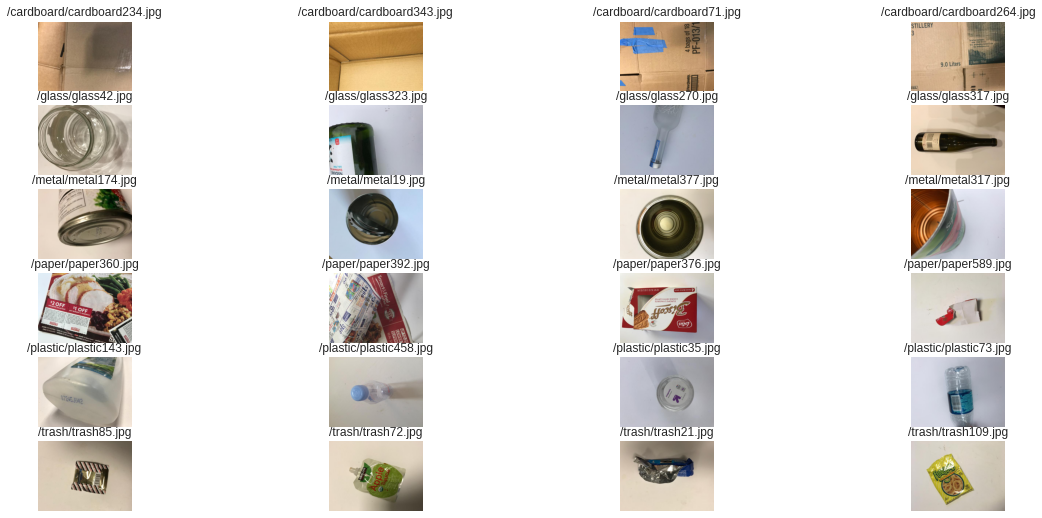

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
plt.style.use("seaborn")
total = 4                                                                       
index = np.random.randint(20)                                                    

plt.figure(figsize=(5*total, 9))

list_cardboard = [os.path.join('/tmp/Garbage classification/Garbage classification/cardboard', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/cardboard')[index:index+total]]
list_glass = [os.path.join('/tmp/Garbage classification/Garbage classification/glass', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/glass')[index:index+total]]
list_metal = [os.path.join('/tmp/Garbage classification/Garbage classification/metal', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/metal')[index:index+total]]
list_paper = [os.path.join('/tmp/Garbage classification/Garbage classification/paper', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/paper')[index:index+total]]
list_plastic = [os.path.join('/tmp/Garbage classification/Garbage classification/plastic', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/plastic')[index:index+total]]
list_trash = [os.path.join('/tmp/Garbage classification/Garbage classification/trash', name) for name in os.listdir('/tmp/Garbage classification/Garbage classification/trash')[index:index+total]]
for i, path in enumerate(list_cardboard+list_glass+list_metal+list_paper+list_plastic+list_trash):
  plt.subplot(6, total, i+1)
  plt.axis('off')

  plt.title(path.replace('/tmp/Garbage classification/Garbage classification', ''))
  img = plt_image.imread(path)
  plt.imshow(img)

## Image Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    horizontal_flip=True,
                    shear_range = 0.25,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(
        train_dir,  # Training Directory
        target_size=(224, 224),  # Changing The Picture Resolution
        batch_size=64,
        # Multiclass problem, so i'm using "categorical" class mode
        class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
        validation_dir, # Validation Directory
        target_size=(224, 224), # Changing the picture resolution
        batch_size=64, # Multiclass problem, so i'm using "categorical" class mode
        class_mode='categorical')

Found 1514 images belonging to 6 classes.
Found 1013 images belonging to 6 classes.


## Callbacks

In [ ]:
import tensorflow as tf

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy")>=0.99):
      print("\nAccuracy has reached 99%, training stop!")
      self.model.stop_training=True

In [ ]:
callbacks = myCallback()

## Transfer Learning

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False,
                                weights="imagenet")

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer("block_14_depthwise_relu")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 960)


## Build The Model

In [ ]:
import tensorflow as tf

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (6, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit(train_gen,
                    epochs=30,
                    steps_per_epoch=20,
                    validation_data = val_gen,
                    verbose=2,
                    validation_steps=5,
                    callbacks=[callbacks])

Epoch 1/30
20/20 - 21s - loss: 32.9701 - accuracy: 0.2552 - val_loss: 5.9472 - val_accuracy: 0.5594
Epoch 2/30
20/20 - 19s - loss: 4.1602 - accuracy: 0.4852 - val_loss: 1.5605 - val_accuracy: 0.5781
Epoch 3/30
20/20 - 18s - loss: 1.1610 - accuracy: 0.6010 - val_loss: 0.8877 - val_accuracy: 0.6781
Epoch 4/30
20/20 - 18s - loss: 0.8278 - accuracy: 0.6582 - val_loss: 0.6765 - val_accuracy: 0.7406
Epoch 5/30
20/20 - 18s - loss: 0.7628 - accuracy: 0.7122 - val_loss: 0.6619 - val_accuracy: 0.7844
Epoch 6/30
20/20 - 18s - loss: 0.7154 - accuracy: 0.7218 - val_loss: 0.6154 - val_accuracy: 0.7969
Epoch 7/30
20/20 - 18s - loss: 0.6274 - accuracy: 0.7711 - val_loss: 0.7318 - val_accuracy: 0.7594
Epoch 8/30
20/20 - 18s - loss: 0.5686 - accuracy: 0.7917 - val_loss: 0.6262 - val_accuracy: 0.7812
Epoch 9/30
20/20 - 18s - loss: 0.5460 - accuracy: 0.8029 - val_loss: 0.5978 - val_accuracy: 0.8062
Epoch 10/30
20/20 - 18s - loss: 0.5512 - accuracy: 0.7953 - val_loss: 0.6236 - val_accuracy: 0.8094
Epoch 11

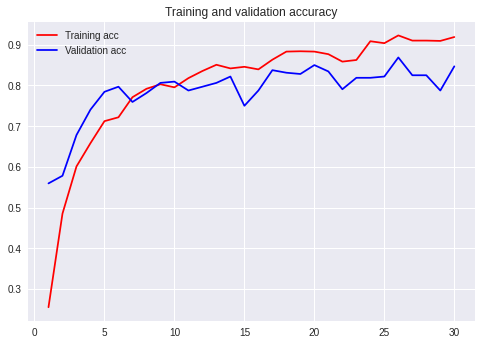

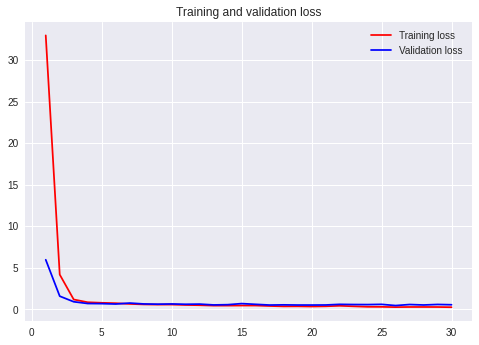

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Saving dawdawdawddaw.png to dawdawdawddaw (1).png


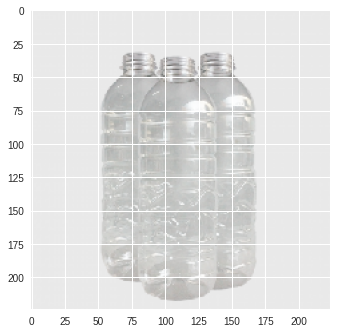

cardboard: 0.23%
glass: 4.04%
metal: 0.80%
paper: 8.43%
plastic: 82.19%
trash: 4.31%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

labels = train_gen.class_indices.keys()

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))